In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.model_selection import GridSearchCV

**Question 1: Segmentation, Assignment Generation,
and Churn Prediction Using Merchant Transaction
Activity**

**Task 1: Feature Generation**

Generate the following features for each unique merchant (You don’t need to do this from
scratch. Use the solution provided from previous homework):

• trans amount min: Minimum transaction amount for each merchant.

• trans amount max: Maximum transaction amount for each merchant.

• trans amount avg: Average transaction amount for each merchant.

• trans amount volume: Total transaction amount for each merchant.

• trans frequency: Total count of transactions for each merchant.

• trans recency: Recency of the last transaction (in days from 1/1/2035).

• avg time btwn trans: Average time between transactions (in hours).

• avg trans growth rate: Average growth rate in transaction amounts.

In [ ]:
raw_data = pd.read_csv('homework7_file1.csv')

,merchant,time,amount_usd_in_cents
0,d087d4c321,2034-12-11 22:16:41,5059
1,fe1cb2e840,2034-08-13 21:11:59,12743
2,878047f4b9,2033-06-05 21:15:00,7601


The following rebuilds the data, as I didn't like the setup I had in the other homework.

In [ ]:
raw_data['usd'] = raw_data['amount_usd_in_cents'] // 100

In [ ]:
raw_data['date'] = pd.to_datetime(raw_data['time'])

In [ ]:
merchant_raw = raw_data.groupby('merchant').agg({'usd': ['min', 'max', 'mean', 'count','sum']}).reset_index()
merchant_raw.columns = ['merchant', 'min_usd', 'max_usd', 'mean_usd', 'count', 'sum']

In [ ]:
merchant_recent = raw_data.groupby('merchant')['date'].max().reset_index(name='date')
merchant_recent['date'] = (pd.to_datetime('2035-01-01') - merchant_recent['date']).dt.days

In [ ]:
date_diff = raw_data.groupby('merchant')['date'].apply(lambda x: x.diff().mean()).reset_index(name='date')

In [ ]:
"""from datetime import date
date_diff = date_diff.apply(lambda x: x.days)"""

'from datetime import date\ndate_diff = date_diff.apply(lambda x: x.days)'

In [ ]:
date_diff.fillna(0, inplace=True)

This is a function to detern the average growth rate by merchant. Then I use groupby and apply to iterate the the usd column and send the new value to a new column.

In [ ]:
def calculate_avg_growth_rate(df):
    df = df.sort_values('date')
    df['growth_rate'] = df['usd'].pct_change()
    avg_growth_rate = df['growth_rate'].mean()
    return avg_growth_rate

avg_growth_rates = raw_data.groupby('merchant').apply(calculate_avg_growth_rate).reset_index(name='avg_growth_rate')
print(avg_growth_rates)

        merchant  avg_growth_rate
0     00057d4302         0.090909
1     000ed1585f        -0.082700
2     000f8c3297         0.229793
3     0020aefbd9              NaN
4     0026f256ac              NaN
...          ...              ...
7897  ffb94e1865         0.227426
7898  ffc46fd720              NaN
7899  ffe1f6b51a         0.112833
7900  ffe26b900d        -0.529010
7901  fff1754102        -0.222222

[7902 rows x 2 columns]


<ipython-input-37-fb0655bc0a7f>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_growth_rates = raw_data.groupby('merchant').apply(calculate_avg_growth_rate).reset_index(name='avg_growth_rate')


In [ ]:
avg_growth_rates.fillna(0, inplace=True)

In [ ]:
date_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7902 entries, 0 to 7901
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   merchant  7902 non-null   object
 1   date      7902 non-null   object
dtypes: object(2)
memory usage: 123.6+ KB


The next cell uses pd.merge to merge all of the newly created fields into a single dataframe for analysis.

In [ ]:
merged_df = pd.merge(merchant_raw, merchant_recent, on='merchant', how='left')
merged_df = pd.merge(merged_df, date_diff, on='merchant', how='left')
merged_df = pd.merge(merged_df, avg_growth_rates, on='merchant', how='left')

**Task 2: Merchant Segmentation**
• Goal: Identify different kinds of businesses in the sample and generate assignments
for each merchant using only the given data.

**Approach:**

  – Use the k-means algorithm to cluster the dataset with the newly created features.

  – Apply silhouette OR elbow method to determine the optimal number of clusters.

  – Conduct exploratory data analysis for each cluster to identify and infer different
  types of businesses.

(Note: This part is open-ended; a box plot of the
features for each cluster may suffice. Some potential business categories could
include high/low growth, frequency, recency, value, volume, or a combination
of these. You are also welcome to define your own categories.)

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_df.select_dtypes(include=['float64', 'int64']))

Here, I use inertia to determine the optimal number of clusters, followed by the silhoette scoring and visual so I can see with is the difference between the two methods. According to the inertia, the optimal number of clusters is 6, but we'll test this with silhoette scoring.

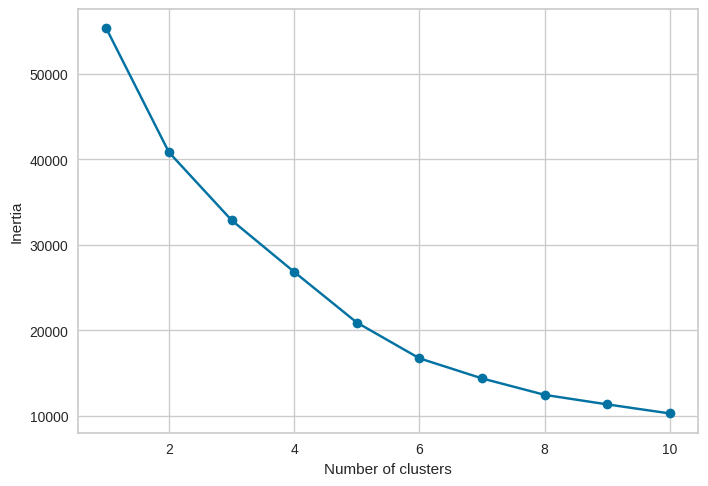

In [ ]:
inertia = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

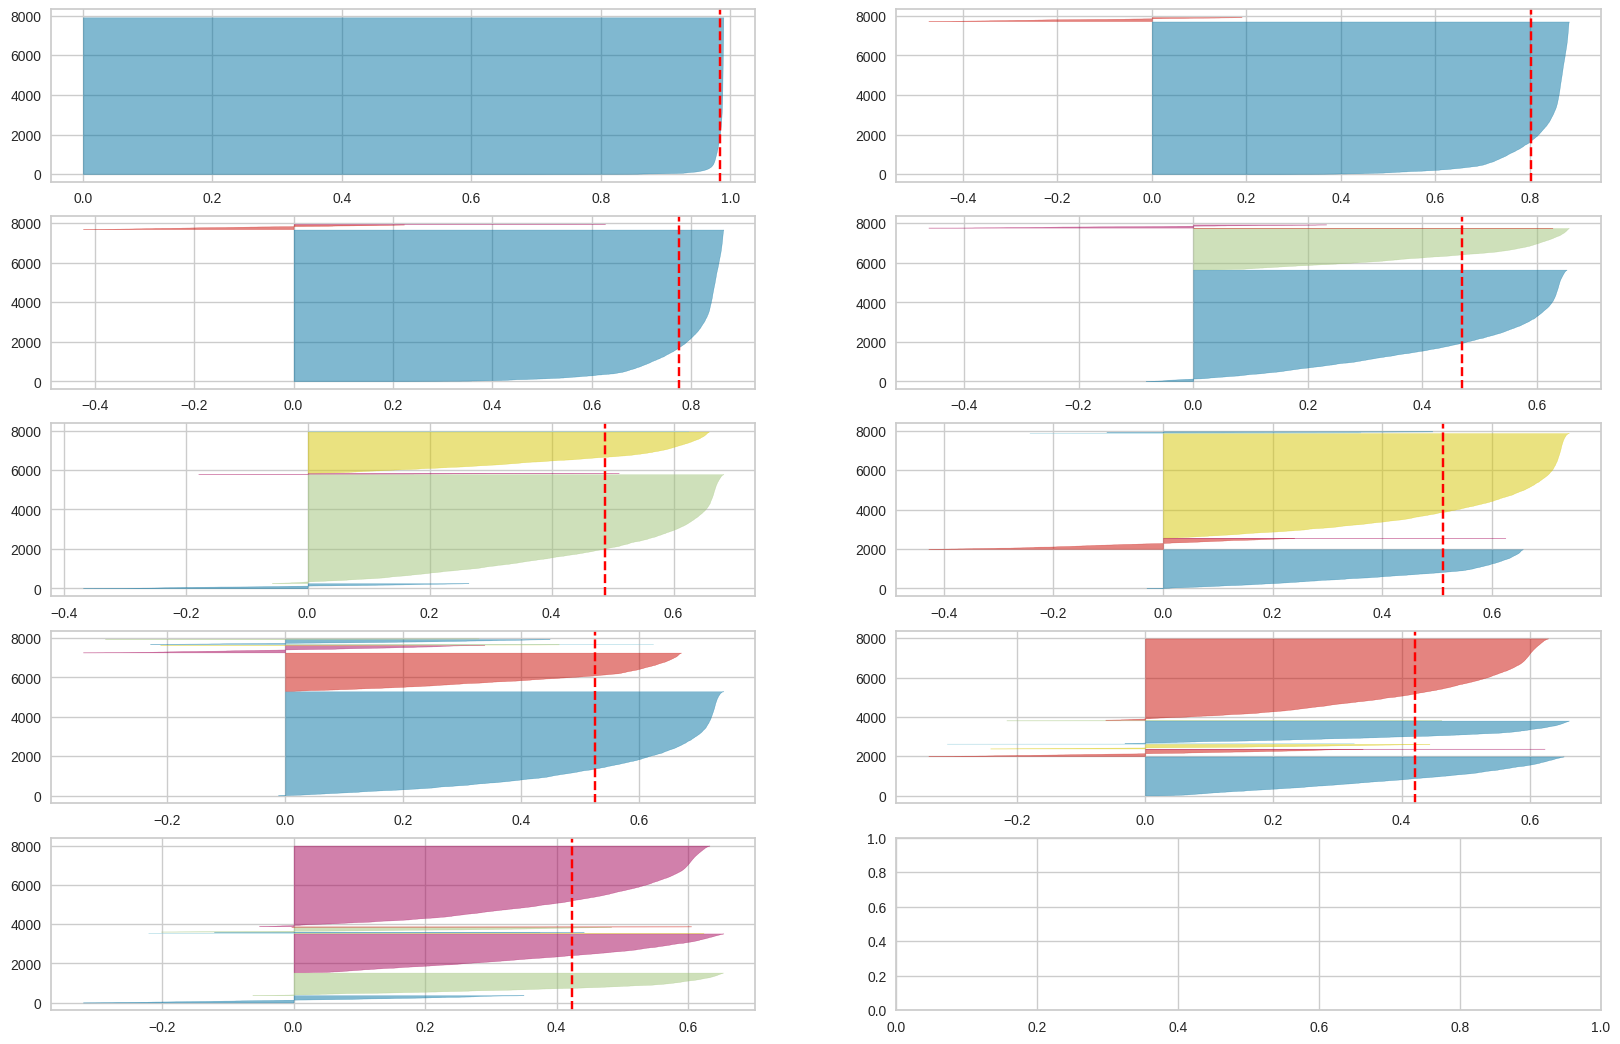

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(20,13))
for i in range(2, 11):  # Start from 2 clusters as silhouette requires at least 2
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i-2, 2)  # Adjust index because i starts from 2
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(scaled_data)


The following is a loop where I test 2-10 clusters for the silhoette score. Based on the model, the highest silhoette score is with 2 clusters.

In [ ]:
for i in range(2, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    labels = km.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    print(f"For n_clusters = {i}, the silhouette score is {score}")


For n_clusters = 2, the silhouette score is 0.9835747375261487
For n_clusters = 3, the silhouette score is 0.8022420681810509
For n_clusters = 4, the silhouette score is 0.7757423932251343
For n_clusters = 5, the silhouette score is 0.4692123527635198
For n_clusters = 6, the silhouette score is 0.4878363211398818
For n_clusters = 7, the silhouette score is 0.5117054089138939
For n_clusters = 8, the silhouette score is 0.5248694634404761
For n_clusters = 9, the silhouette score is 0.42032428567832597
For n_clusters = 10, the silhouette score is 0.4238749344948682


The following creates my KMeans cluster, where I actually use four clusters because I want to have a greater number of segmentation clusters. The optimal number is indeed 2, so this is purely an academic exercise.

In [ ]:
km = KMeans(n_clusters=4, random_state=42)
cluster_labels = km.fit_predict(scaled_data)
merged_df['Cluster'] = cluster_labels


Here I take my clusters and thread them back into each merchant's row of data for further analysis.

In [ ]:
merged_df['Cluster'].unique()

array([0, 2, 3, 1], dtype=int32)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7902 entries, 0 to 7901
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   merchant         7902 non-null   object 
 1   min_usd          7902 non-null   int64  
 2   max_usd          7902 non-null   int64  
 3   mean_usd         7902 non-null   float64
 4   count            7902 non-null   int64  
 5   sum              7902 non-null   int64  
 6   date_x           7902 non-null   int64  
 7   date_y           7902 non-null   object 
 8   avg_growth_rate  7902 non-null   float64
 9   Cluster          7902 non-null   int32  
dtypes: float64(2), int32(1), int64(5), object(2)
memory usage: 586.6+ KB


Here is where the data gets a bit more interesting where I now groupby cluster using min, max, mean, and count. This will enable greater and more meaningful segmentaion.

In [ ]:
merged_analytics = merged_df.groupby('Cluster').agg({'sum': ['min', 'max', 'mean', 'count']}).reset_index()
merged_analytics.columns = ['Cluster', 'min_sum', 'max_sum', 'mean_sum', 'count']
merged_analytics

,Cluster,min_sum,max_sum,mean_sum,count
0,0,2,20270,1210.669885,7664
1,1,103855,103855,103855.000000,1
2,2,4006,154845,25851.726496,234
3,3,3020,20206,11617.000000,3


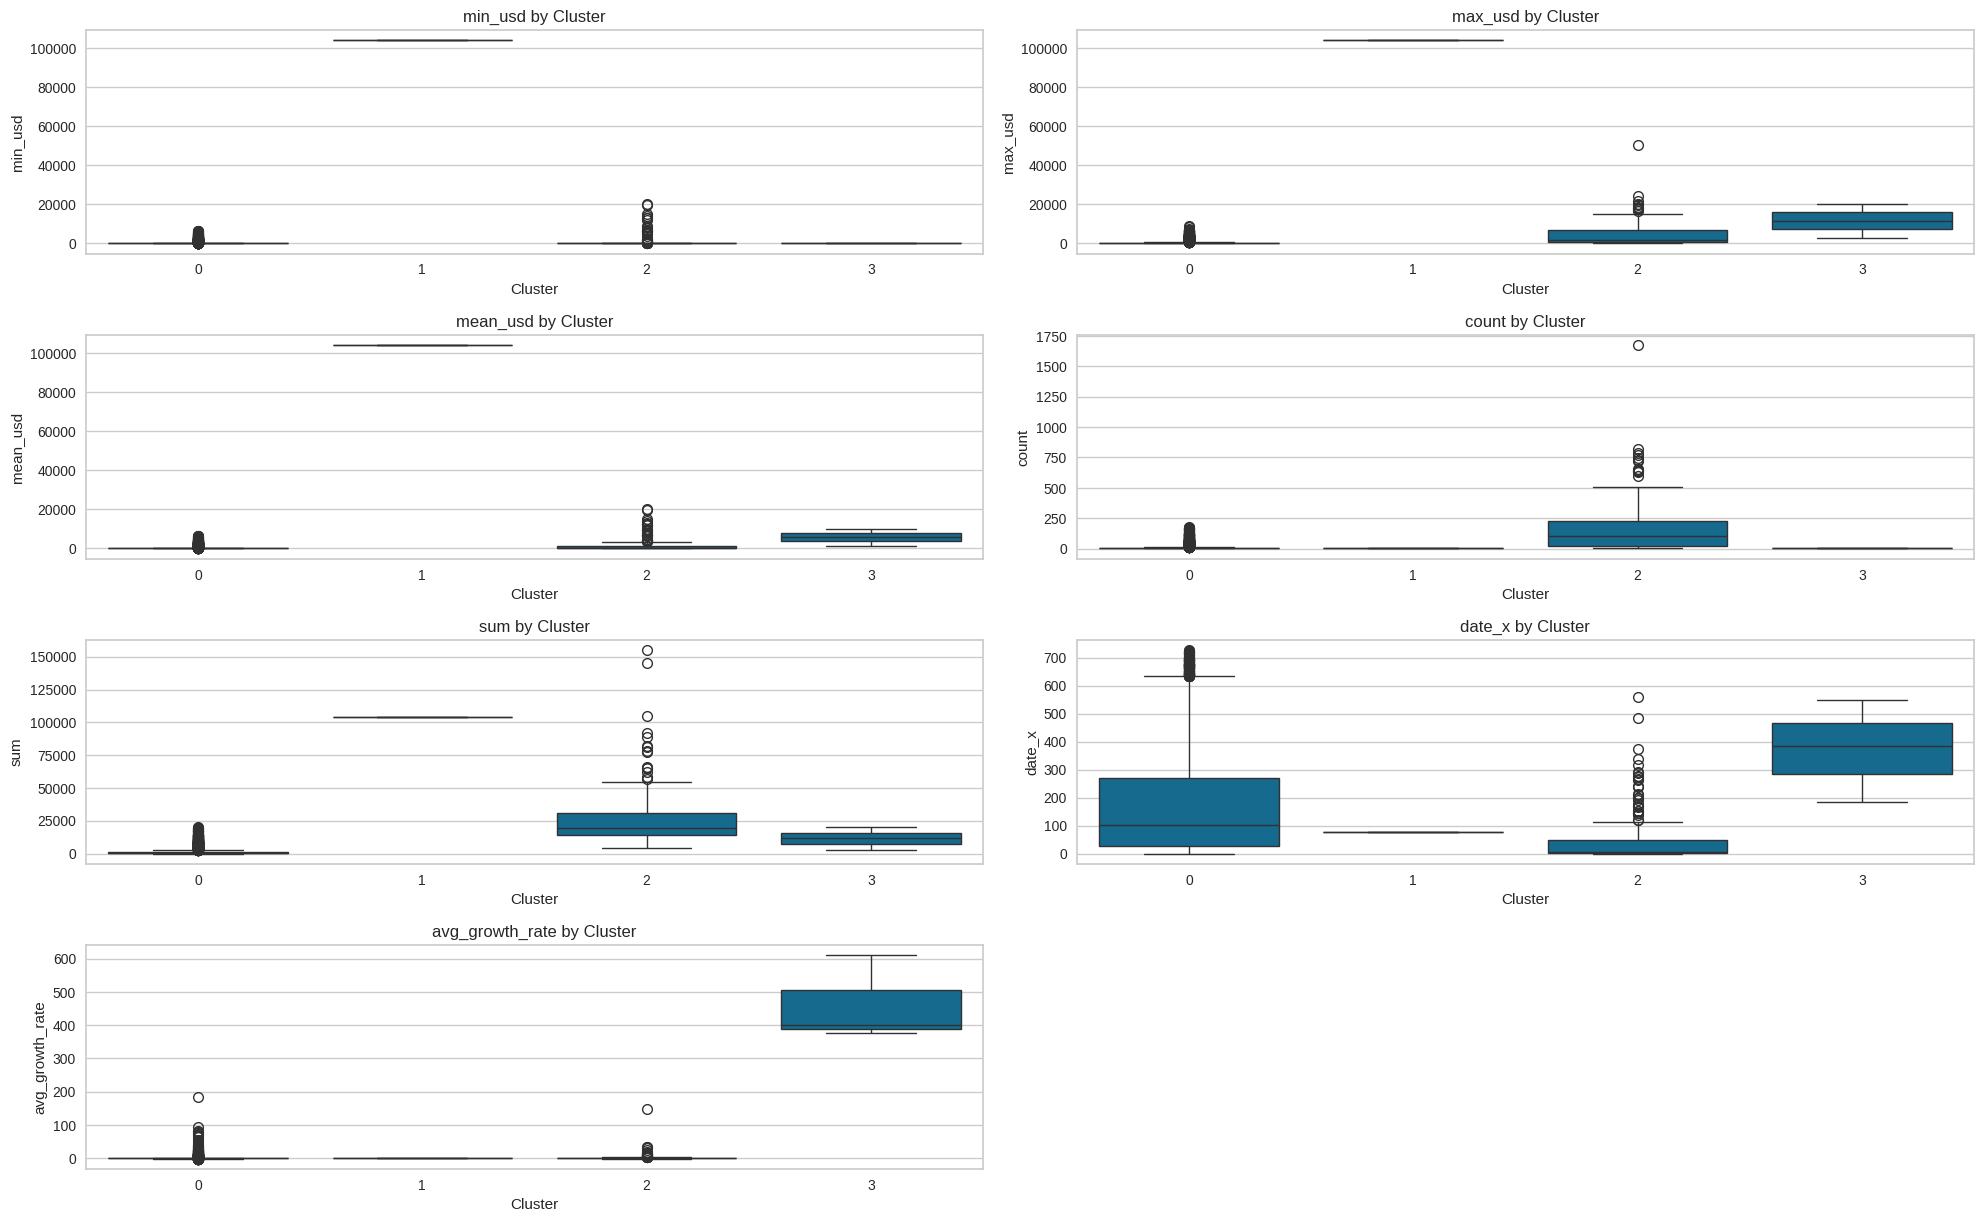

In [ ]:
plt.figure(figsize=(20, 15))
for i, column in enumerate(merged_df.select_dtypes(include=['float64', 'int64']).columns, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(x='Cluster', y=column, data=merged_df)
    plt.title(f'{column} by Cluster')
plt.tight_layout()
plt.show()


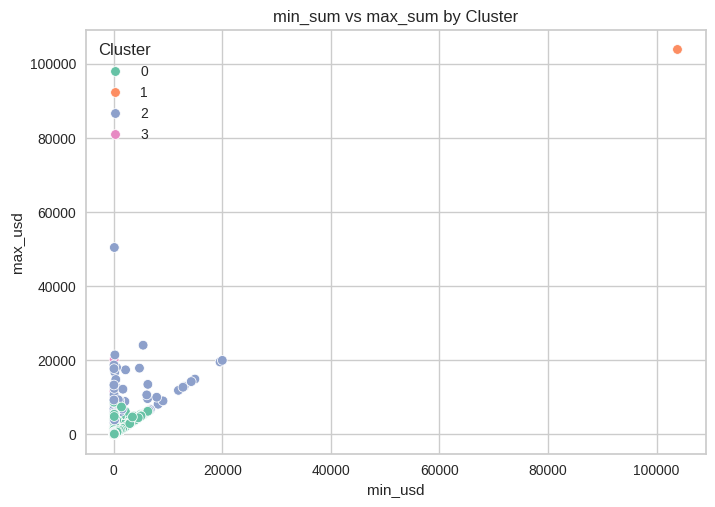

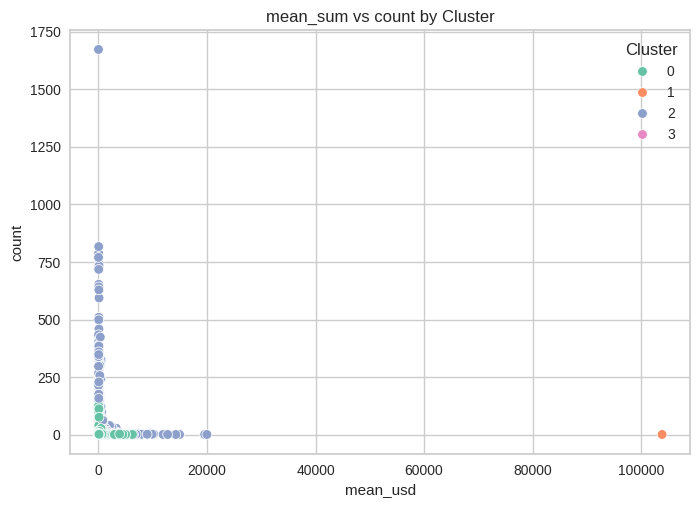

In [ ]:
sns.scatterplot(data=merged_df, x='min_usd', y='max_usd', hue='Cluster', palette='Set2')
plt.title('min_sum vs max_sum by Cluster')
plt.show()

sns.scatterplot(data=merged_df, x='mean_usd', y='count', hue='Cluster', palette='Set2')
plt.title('mean_sum vs count by Cluster')
plt.show()

In [ ]:
cluster_names = {
    0: 'High Volume, Moderate Value',
    1: 'Low Volume, High Value',
    2: 'Medium Volume, Moderate to High Value',
    3: 'Low Volume, Low Value'
}

merged_df['Cluster_Type'] = merged_df['Cluster'].map(cluster_names)

merged_df.groupby(['Cluster_Type','Cluster']).agg({'min_usd': ['min', 'max', 'mean', 'count']}).reset_index()

Cluster_Type Cluster min_usd          \
                                                     min     max   
0            High Volume, Moderate Value       0       2    6399   
1                 Low Volume, High Value       1  103855  103855   
2                  Low Volume, Low Value       3       8      50   
3  Medium Volume, Moderate to High Value       2       2   19989   

                        
            mean count  
0     168.908925  7664  
1  103855.000000     1  
2      25.666667     3  
3     892.884615   234

In this dataset, the optimal cluster score was 2 clusters, however, I wanted to make the analysis a bit more interesting. Thus, I used 4 clusters, which still had a silhouette score of 77. The analysis looked at the merchant data and found interesting results. There are two clusters worth focusing on: High Volume, Moderate Value and Medium Volume, Moderate to High Value. The business strategy would focus on the High Volume, Moderate Value, which would ensure consistent and reliable sales. Next, the growth strategy would focus on Medium Volume, Moderate to High Value merchants to grow the business.

**Task 3: Churn Prediction**

Background: Customer retention is a key growth pillar. Churn or customer
attrition is defined as customers who have had no transactions within a 30-day
period, indicating a ”rolling” Monthly Recurring Revenue (MRR) of $0.

Goal: Develop a churn prediction model.

  – Generate binary labels for churn and no churn based on the 30-day inactivity
  criterion (Hint: Calculate the maximum time between transactions for each
  user, including from their last transaction to a set max date. Label users as
  ’Churned’ if the gap exceeds 30 days, and ’Not Churned’ otherwise).

  – Use the generated features, binary labels (target) with the Random Forest
  algorithm to develop a classification model to predict churn.

  – Present classification metrics from your experiment.

  – Optional - Present a feature importance plot from your model

In [ ]:
raw_data['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 100000 entries, 0 to 99999
Series name: date
Non-Null Count   Dtype         
--------------   -----         
100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 781.4 KB


Here, I create a copy of the initial dataset so that I am able to work with and overwrite the data.

In [ ]:
churn_data = raw_data.sort_values(by='date', ascending=False).copy()

In [ ]:
churn_data.groupby('merchant').agg({'date': ['max']}).reset_index()

,merchant,time,amount_usd_in_cents,usd,date
17644,913696f5ff,2034-12-31 07:55:58,5370,53,2034-12-31 07:55:58
73444,7851aedb5b,2034-12-31 07:27:21,5205,52,2034-12-31 07:27:21


Here I use a lambda function to groupby, aggregate, and calculate the date difference between the min and max dates of a given merchant. This will serve as the foundation for determining churned or not churned.

In [4]:
date_diff = churn_data.groupby('merchant')['date'].agg(lambda x: (x.max() - x.min()).days)
date_diff_df = date_diff.reset_index()
date_diff_df.columns = ['merchant', 'Days_Difference']

"date_diff = churn_data.groupby('merchant')['date'].agg(lambda x: (x.max() - x.min()).days)\ndate_diff_df = date_diff.reset_index()\ndate_diff_df.columns = ['merchant', 'Days_Difference']"

Here is were I build the binary column based on merchant with greater than 30 days since transaction and assign 1 or 0 as an output.

In [5]:
date_diff_df['Churned'] = np.where(date_diff_df['Days_Difference'] >= 30, 1, 0)

"date_diff_df['Churned'] = np.where(date_diff_df['Days_Difference'] >= 30, 1, 0)"

In [ ]:
date_diff_df.head()

,merchant,Days_Difference,Churned
0,00057d4302,0,0
1,000ed1585f,428,1
2,000f8c3297,317,1
3,0020aefbd9,0,0
4,0026f256ac,0,0


The churned value counts indicate that the data is fairly balanced, so shouldn't need to deal with imbalanced data.

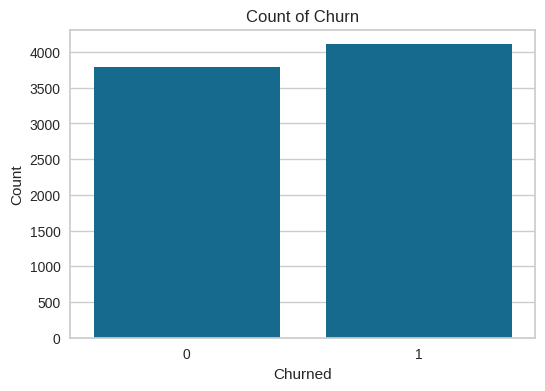

In [ ]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='Churned', data=date_diff_df, ax=ax)
ax.set_xlabel("Churned")
ax.set_ylabel("Count")
plt.title("Count of Churn")
plt.show()

The following cell displays the % of merchants that are classified as churned. It appears that 51% of merchants are churned, which would warrant further investigation.

In [ ]:
n=len(date_diff_df)
churn_0=len(date_diff_df[date_diff_df['Churned']==0])
churn_1=len(date_diff_df[date_diff_df['Churned']==1])

print("% of Mercants churned: ",churn_1*100/n)
print("% of Merchants not churned: ",churn_0*100/n)

% of Mercants churned:  51.96152872690458
% of Merchants not churned:  48.03847127309542


The following code I began to build the final dataset to be used in the random forest classifier and final output.

In [ ]:
merged_df = pd.merge(merged_df, date_diff_df, on='merchant', how='left')

In [ ]:
merged_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns
temp_df = merged_df[merged_columns]
X = temp_df.drop(['Churned', 'Days_Difference', 'min_usd', 'max_usd'], axis=1)
y = temp_df['Churned']

Here, I create a correlation plot. I'd run correlation several times and determined that Days_Difference, min_usd, and max_usd were strongly correlated and thus caused variance inflation and overfitting. Now, the correlation looks much better and less prone to overfitting.

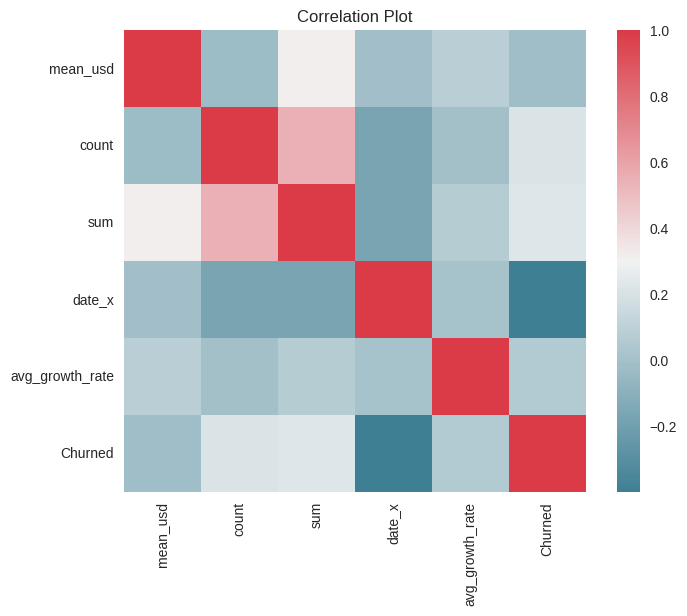

In [ ]:
cor = temp_df.drop(['Days_Difference', 'min_usd', 'max_usd'], axis=1).corr()
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Here, I use grid search cv to perform paramter hypertuning. The best hyperparameters are displayed below.

In [ ]:
rf = RandomForestClassifier()
params = {
    'max_depth': [3,5,7,10],
    'n_estimators': [5, 10, 20],
    'max_features': [10, 20, 30 , 40],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(rf, params, cv = 3, scoring='accuracy', verbose = 0)
model_grid = grid.fit(X_train_scaled, y_train)

print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Best hyperparameters are {'max_depth': 5, 'max_features': 40, 'min_samples_leaf': 1, 'n_estimators': 10}
Best score is: 0.8751779781680114


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
rf_final = RandomForestClassifier(max_depth=5, max_features=40, min_samples_leaf=1, n_estimators=10)
rf_final.fit(X_train_scaled, y_train)
y_pred = rf_final.predict(X_test_scaled)

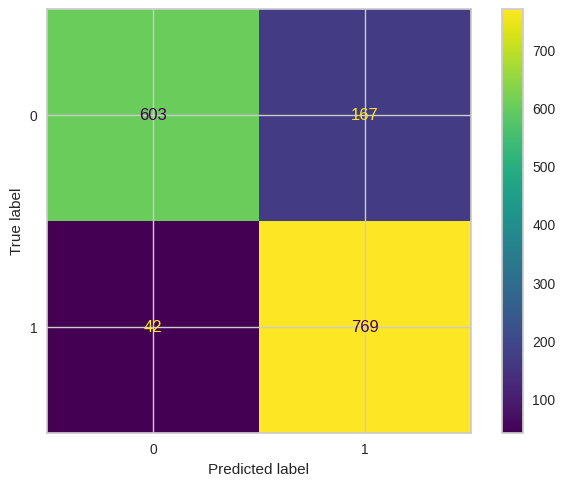

              precision    recall  f1-score   support

           0       0.93      0.78      0.85       770
           1       0.82      0.95      0.88       811

    accuracy                           0.87      1581
   macro avg       0.88      0.87      0.87      1581
weighted avg       0.88      0.87      0.87      1581



In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred))


•	The Random Forest Classifier model on the merchant data, has higher precision for class 0. This means the model is better at avoiding false positives for class 0. However, the model has higher recall for class 1, indicating the model is better at predicting true positives for class 1.

•	The model's F1-scores indicate that the model is overal efficient at predicting both classes, with a slight advantage when predicting the "Not Churned" class.

•	The model's accuracy of 87% indicates that the model is predicting well overall, but the users should remain wary of this metric, as it doesn't always perform as well as the other evaluation metrics.


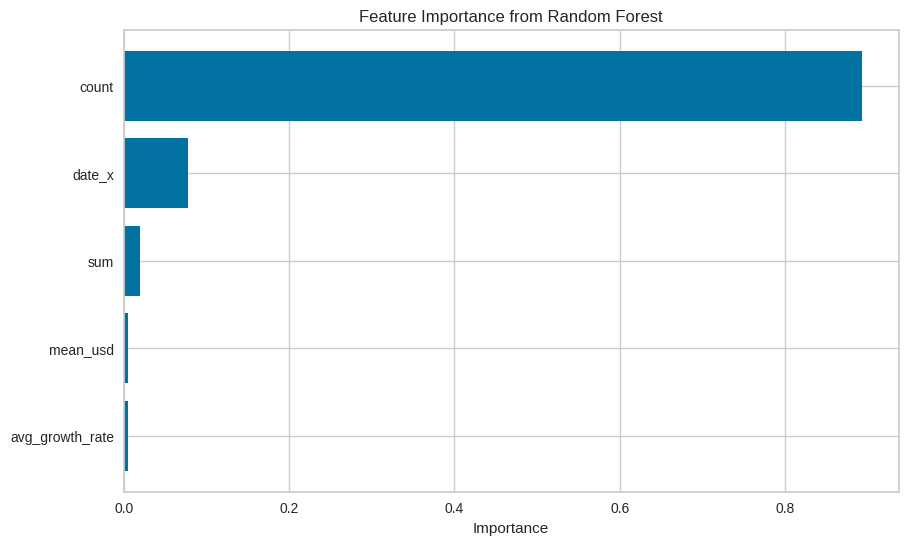

In [ ]:
importances = rf_final.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

The count of merchant transactions is the most important feature in the model with an importance of 0.89. The other features, such as date_x and sum are of less importance with an importance of 0.077 and 0.019 respectively. Features like mean_usd and avg_growth_rate have a negligible importance, indicating they do not significantly influence the model's predictions.

**Question 2: Machine Learning Model Interpretability**
See Additional PDF File